# Week 1 Mini Project: Embedding Dimension vs Latency & Memory

This notebook explores how **embedding dimension, batch size, and sequence length**
affect **latency and memory usage** in a simplified AI inference workload.
The goal is to build intuition relevant to an **AI Systems Engineer**:
understanding how linear algebra choices directly translate into
real performance and resource trade-offs.

In [35]:
# Core libraries for tensor computation and timing
import torch
import time

# Data handling and visualization
import pandas as pd
import matplotlib.pyplot as plt

## Experiment Setup

We simulate a simplified inference-like workload using:

- Random input tensors (representing embeddings)
- Matrix multiplication (representing linear layers / attention projections)

Key parameters:
- **Batch Size**: number of parallel requests
- **Sequence Length**: number of tokens per request
- **Embedding Dimension**: width of representation space

All experiments are run on CPU to highlight raw scaling behavior
without GPU-specific optimizations.

In [36]:
# Batch sizes simulate different levels of request concurrency
batch_sizes = [8, 16, 32, 64]

# Sequence lengths simulate short vs long context workloads
seq_lens = [512, 1024]

# Embedding dimensions simulate model width
dimensions = [128, 256, 512, 1024]

device = "cpu"


## Measurement Methodology

For each combination of:
- `batch_sizes`
- `seq_lens`
- `dimensions`

We measure:
- **Latency (ms)** for a single forward matrix multiplication
- **Approximate memory usage (MB)** of the input tensor

Each measurement includes a warm-up run to reduce initialization noise.

In [ ]:
results = [] # To store results

for b in batch_sizes:
    for s in seq_lens:
        for dim in dimensions:
            # Create random input and weight tensors
            x = torch.randn(b, s, dim, device=device)
            W = torch.randn(dim, dim, device=device)

            # Warm-up run to avoid one-time setup overhead
            _ = x @ W

            # Measure execution time of matrix multiplication
            start = time.time()
            y = x @ W
            end = time.time()

            latency_ms = (end - start) * 1000  # Convert to milliseconds
            # Approximate memory footprint of input tensor
            # (number of elements × bytes per element)
            memory_mb = x.numel() * x.element_size() / (1024 ** 2)

            results.append((b, s, dim, latency_ms, memory_mb))

## Raw Results Summary

The table below contains measured latency and memory usage for all combinations of parameters. 
These raw numbers form the basis for identifying scaling trends and performance bottlenecks.

In [37]:
import pandas as pd

df = pd.DataFrame(results, columns=['Batch Size', 'Sequence Length', 'Dimension', 'Latency (ms)', 'Memory (MB)'])
df

,Batch Size,Sequence Length,Dimension,Latency (ms),Memory (MB)
0,8,512,128,3.999472,2.0
1,8,512,256,8.989811,4.0
2,8,512,512,20.426989,8.0
3,8,512,1024,37.001371,16.0
4,8,1024,128,1.998186,4.0
5,8,1024,256,4.999638,8.0
6,8,1024,512,21.000624,16.0
7,8,1024,1024,73.999166,32.0
8,16,512,128,1.998901,4.0
9,16,512,256,4.999638,8.0


## Latency Scaling Visualization

To understand interactions between parameters, we plot:

- Latency vs Embedding Dimension
- One plot per sequence length
- Multiple lines per plot, one for each batch size

This allows us to observe:
- Linear vs non-linear growth
- Effects of batching under memory pressure

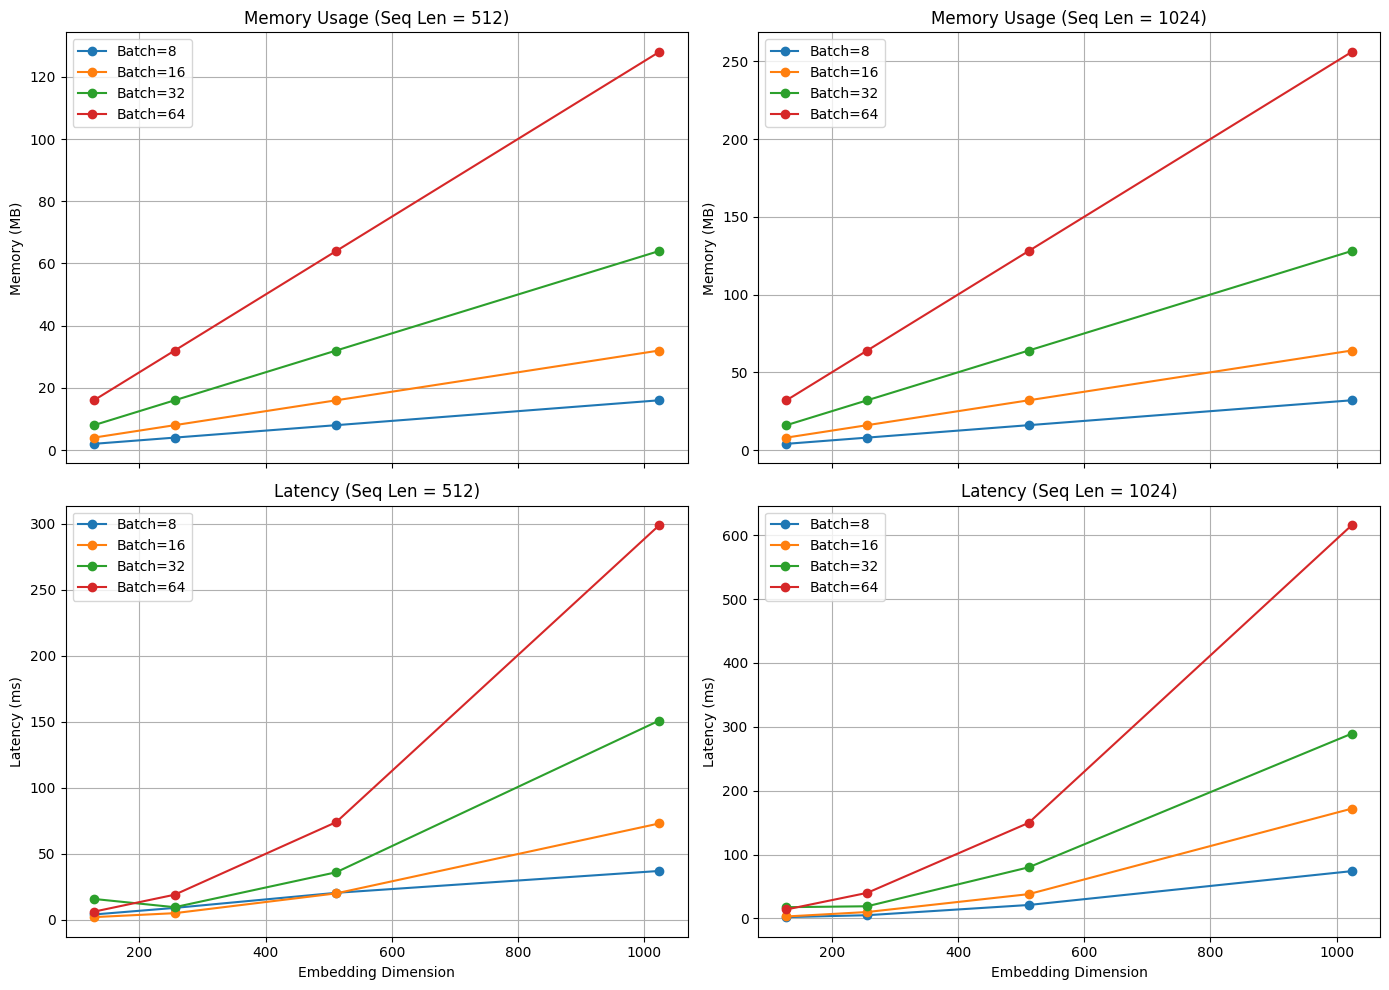

In [38]:
"""
============================================================
Visualization: Memory and Latency Scaling with Dimension

This cell visualizes how embedding dimension affects:
1) Memory usage (MB)
2) Latency (ms)

For each sequence length, we plot multiple batch sizes
on the same axis to clearly show trade-offs.

This mirrors how AI Systems Engineers analyze inference
behavior under different workload configurations.
============================================================
"""

import matplotlib.pyplot as plt

batch_sizes = [8, 16, 32, 64]
seq_lens = [512, 1024]

# Create a 2x2 grid:
# Row 0 -> Memory plots
# Row 1 -> Latency plots
# Column 0 -> Seq Len = 512
# Column 1 -> Seq Len = 1024
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(14, 10),
    sharex="col"
)

for col, seq in enumerate(seq_lens):

    # -----------------------------
    # MEMORY PLOT (Top Row)
    # -----------------------------
    ax_mem = axes[0, col]

    for batch in batch_sizes:
        subset = df[
            (df["Sequence Length"] == seq) &
            (df["Batch Size"] == batch)
        ].sort_values("Dimension")

        ax_mem.plot(
            subset["Dimension"],
            subset["Memory (MB)"],
            marker="o",
            label=f"Batch={batch}"
        )

    ax_mem.set_title(f"Memory Usage (Seq Len = {seq})")
    ax_mem.set_ylabel("Memory (MB)")
    ax_mem.grid(True)
    ax_mem.legend()

    # -----------------------------
    # LATENCY PLOT (Bottom Row)
    # -----------------------------
    ax_lat = axes[1, col]

    for batch in batch_sizes:
        subset = df[
            (df["Sequence Length"] == seq) &
            (df["Batch Size"] == batch)
        ].sort_values("Dimension")

        ax_lat.plot(
            subset["Dimension"],
            subset["Latency (ms)"],
            marker="o",
            label=f"Batch={batch}"
        )

    ax_lat.set_title(f"Latency (Seq Len = {seq})")
    ax_lat.set_xlabel("Embedding Dimension")
    ax_lat.set_ylabel("Latency (ms)")
    ax_lat.grid(True)
    ax_lat.legend()

plt.tight_layout()
plt.show()

## Interpretation

**Memory Scaling**
- Memory increases linearly with embedding dimension.
- Batch size and sequence length multiply this effect.
- This reflects the raw cost of storing higher-dimensional vectors.

**Latency Scaling**
- Latency grows non-linearly at higher dimensions.
- Larger batch sizes help at small dimensions but hurt once memory pressure dominates.
- Longer sequence length amplifies both compute and memory costs.

**Systems Insight**
Memory growth is predictable and linear, but latency is governed by
hardware thresholds such as cache limits and memory bandwidth saturation.

## AI Systems Engineer Takeaway

This experiment demonstrates that performance in AI systems is governed by
**interacting factors**, not single parameters.

Embedding dimension, batch size, and sequence length multiply together to
determine memory footprint and compute cost. Once hardware limits are crossed,
latency increases non-linearly.

Designing production AI systems requires balancing these factors rather than
maximizing any single one.

## Next Steps

Future extensions of this experiment could include:
- Measuring latency distributions (p95 / p99)
- Adding throughput (tokens/sec)
- Running on GPU and comparing behavior
- Introducing reduced precision (FP16)

These steps move closer to real-world AI inference systems.